# Runoff timeseries
***

***Author:** Chus Casado Rodríguez*<br>
***Date:** 29-01-2025*<br>

**Introduction**<br>
This notebook analyses the variability in monthly global runoff, and compares it with the El Niño-Southern Oscillation (ENSO) and the Pacific Decadal Oscillation (PDO).

**Output**<br>
* *runoff_interannual_variability.csv*: monthly time series of global runoff anomaly, ENSO ONI index, and PDO.

In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from pathlib import Path
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from pathlib import Path

## Configuration

In [2]:
VAR = 'runoff'

# inputs
PATH_IN = Path('../data') 
TS_FILE = PATH_IN / 'GloFAS' / VAR / f'{VAR}_monthly_mean_1979-2024.nc'
ENSO_FILE = PATH_IN / 'teleconnections' / 'ENSO_ONI.txt'
PDO_FILE = PATH_IN / 'teleconnections' / 'PDO.txt'

# outputs
PATH_OUT = Path('../results') / VAR
PATH_PLOT = PATH_OUT / 'plots'
PATH_PLOT.mkdir(parents=True, exist_ok=True)

# climatology
START = datetime(1991, 1, 1)
END = datetime(2020, 12, 31)

In [3]:
map_variables = {
    'runoff': 'rowe',
    'discharge': 'dis24'
}

var_shortname = map_variables[VAR]

## Data

### Runoff

In [4]:
# load time series of monthly average runoff
runoff = xr.open_dataset(TS_FILE)[var_shortname]
runoff = runoff.drop_vars('surface', errors='ignore')
runoff = runoff.to_pandas()
runoff.name = 'runoff'

# change index to the start of the month
runoff.index = [datetime(idx.year, idx.month, 1) for idx in runoff.index]

### Teleconnections

#### ENSO ONI

In [5]:
# load time series of ENSO ONI index
enso = pd.read_csv(ENSO_FILE, skiprows=1, index_col='Year')
enso.columns = range(1, 13)
enso = enso.stack()
enso.name = 'ONI'

# change index to the start of the month and crop to the study period
enso.index = [datetime(year, month, 1) for year, month in enso.index]
enso = enso.loc[runoff.index.min():runoff.index.max()]

#### PDO

In [6]:
# load time series of the Pacific Decadal Oscillation
pdo = pd.read_csv(PDO_FILE, skiprows=1, index_col='Year')
pdo.columns = range(1, 13)
pdo = pdo.stack()
pdo.name = 'PDO'

# change index to the start of the month and crop to the study period
pdo.index = [datetime(year, month, 1) for year, month in pdo.index]
pdo = pdo.loc[runoff.index.min():runoff.index.max()]

## Processing

In [7]:
# climatology
climatology = runoff.loc[START:END].mean()

# monthly anomaly
anomaly = runoff - climatology
anomaly.name = 'anomaly'

# 12-month moving average of the anomaly
anomaly_ma12 = anomaly.rolling(12, center=True).mean()

### Plot

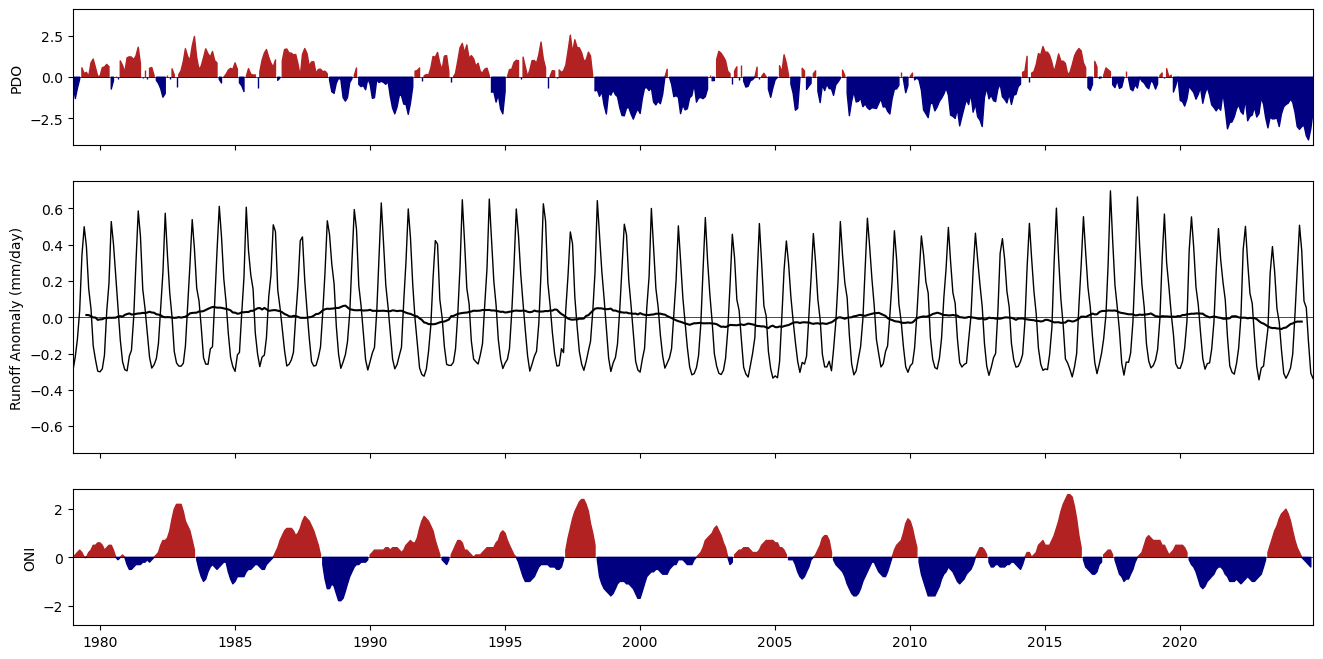

In [8]:
fig = plt.figure(figsize=(16, 8))
gs = gridspec.GridSpec(3, 1, height_ratios=[1, 2, 1])

# PDO
# ---

ax1 = fig.add_subplot(gs[0, 0])
ax1.axhline(0, c='k', lw=.5)

# plot PDO positive phases
pdo_pos = pdo.copy()
pdo_pos[pdo < 0] = np.nan
ax1.fill_between(pdo_pos.index, pdo_pos, color='firebrick')

# plot PDO negative phases
pdo_neg = pdo.copy()
pdo_neg[pdo > 0] = np.nan
ax1.fill_between(pdo_neg.index, pdo_neg, color='navy')

vmax = np.nanmax([abs(x) for x in ax1.get_ylim()])
ax1.set(
    xlim=(runoff.index.min(), runoff.index.max()),
    xticklabels=[],
    ylim=(-vmax, vmax),
    ylabel='PDO'
);

# RUNOFF
# ------

ax2 = fig.add_subplot(gs[1, 0], sharex=ax1)
ax2.axhline(0, c='k', lw=.5)

ax2.plot(anomaly, c='k', lw=1)
ax2.plot(anomaly_ma12, c='k', lw=1.5)

vmax = np.nanmax([abs(x) for x in ax2.get_ylim()])
ax2.set(
    ylim=(-vmax, vmax),
    ylabel='Runoff Anomaly (mm/day)'
)

# ENSO
# ----

ax3 = fig.add_subplot(gs[2, 0])
ax3.axhline(0, c='k', lw=.5)

enso_pos = enso.copy()
enso_pos[enso < 0] = np.nan
ax3.fill_between(enso_pos.index, enso_pos, color='firebrick')

enso_neg = enso.copy()
enso_neg[enso > 0] = np.nan
ax3.fill_between(enso_neg.index, enso_neg, color='navy')

vmax = np.nanmax([abs(x) for x in ax3.get_ylim()])
ax3.set(
    xlim=(runoff.index.min(), runoff.index.max()),
    ylim=(-vmax, vmax),
    ylabel='ONI'
);

plt.savefig(PATH_PLOT / 'interannual_variability.jpg', dpi=300, bbox_inches='tight')

### Export

In [9]:
# concatenate the three time series used in the plots
df = pd.concat([anomaly, enso, pdo], axis=1)
df.index.name = 'date'

# export
output_file = PATH_OUT / 'runoff_interannual_variability.csv'
df.to_csv(output_file, float_format='%.3f')
print(f'Interannual variability of runoff saved in:\t{output_file}')

Interannual variability of runoff saved in:	..\results\runoff\runoff_interannual_variability.csv
